## 1. Load Dataset

In [2]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, img_dir, label_dir, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(img_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
        self.label_files = [f.replace('.png', '.txt').replace('.jpg', '.txt').replace('.jpeg', '.txt') for f in self.image_files]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):

        img_path = os.path.join(self.img_dir, self.image_files[idx])
        label_path = os.path.join(self.label_dir, self.label_files[idx])
        image = Image.open(img_path).convert("RGB")
        # 读取标签
        with open(label_path, 'r') as file:
            label = file.read().strip()
            
        if label:
            # 应用转换
            if self.transform:
                
                image = self.transform(image)
                label = torch.tensor(int(label[0]))
            return image, label
        else:
            return None

    
# data is normalized
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


# train_img_dir = '/kaggle/input/road-sign-recognition/dataset/train/images'
# train_label_dir = '/kaggle/input/road-sign-recognition/dataset/train/labels'
train_img_dir = 'train/images'
train_label_dir = 'train/labels'

# valid_img_dir = '/kaggle/input/road-sign-recognition/dataset/valid/images'
# valid_label_dir = '/kaggle/input/road-sign-recognition/dataset/valid/labels'
valid_img_dir = 'valid/images'
valid_label_dir = 'valid/labels'

# test_img_dir = '/kaggle/input/road-sign-recognition/dataset/test/images'
# test_label_dir = '/kaggle/input/road-sign-recognition/dataset/test/labels'
test_img_dir = 'test/images'
test_label_dir = 'test/labels'


batch_size = 10
train_data = CustomDataset(img_dir=train_img_dir, label_dir=train_label_dir, transform=transform)
train_data = [sample for sample in train_data if sample is not None]
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

valid_data = CustomDataset(img_dir=valid_img_dir, label_dir=valid_label_dir, transform=transform)
valid_data = [sample for sample in valid_data if sample is not None]
valid_dataloader = DataLoader(valid_data, batch_size=batch_size, shuffle=True)

test_data = CustomDataset(img_dir=test_img_dir, label_dir=test_label_dir, transform=transform)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


for images, labels in train_dataloader:
    print(images.shape, labels)
    break


torch.Size([10, 3, 224, 224]) tensor([1, 7, 5, 0, 0, 1, 8, 3, 0, 7])


In [4]:
from collections import defaultdict

train_counts = defaultdict(int)
valid_counts = defaultdict(int)
test_counts = defaultdict(int)

for _, label in train_data:

    label = label.item()
    train_counts[label] += 1
for _, label in valid_data:
    label = label.item() 
    valid_counts[label] += 1
for _, label in test_data:
    label = label.item()
    test_counts[label] += 1

print(train_counts)
print(valid_counts)
print(test_counts)

defaultdict(<class 'int'>, {0: 267, 6: 243, 7: 249, 4: 251, 2: 194, 3: 248, 5: 247, 1: 264, 8: 261})
defaultdict(<class 'int'>, {8: 50, 2: 37, 4: 49, 0: 50, 7: 50, 1: 50, 5: 45, 6: 45, 3: 48})
defaultdict(<class 'int'>, {8: 25, 6: 23, 4: 25, 7: 25, 5: 22, 0: 25, 3: 25, 1: 25, 2: 17})


In [3]:
print(test_data[0])

(tensor([[[0.4824, 0.4824, 0.4824,  ..., 0.2784, 0.2784, 0.2784],
         [0.4824, 0.4824, 0.4824,  ..., 0.2784, 0.2784, 0.2784],
         [0.4824, 0.4824, 0.4824,  ..., 0.2784, 0.2784, 0.2784],
         ...,
         [0.7686, 0.7686, 0.7686,  ..., 0.5647, 0.5647, 0.5647],
         [0.7686, 0.7686, 0.7686,  ..., 0.5647, 0.5647, 0.5647],
         [0.7686, 0.7686, 0.7686,  ..., 0.5647, 0.5647, 0.5647]],

        [[0.4863, 0.4863, 0.4863,  ..., 0.2824, 0.2824, 0.2824],
         [0.4863, 0.4863, 0.4863,  ..., 0.2824, 0.2824, 0.2824],
         [0.4863, 0.4863, 0.4863,  ..., 0.2824, 0.2824, 0.2824],
         ...,
         [0.7490, 0.7490, 0.7490,  ..., 0.5294, 0.5294, 0.5294],
         [0.7490, 0.7490, 0.7490,  ..., 0.5294, 0.5294, 0.5294],
         [0.7490, 0.7490, 0.7490,  ..., 0.5294, 0.5294, 0.5294]],

        [[0.5059, 0.5059, 0.5059,  ..., 0.3020, 0.3020, 0.3020],
         [0.5059, 0.5059, 0.5059,  ..., 0.3020, 0.3020, 0.3020],
         [0.5059, 0.5059, 0.5059,  ..., 0.3020, 0.3020, 0

## 2. Model Setup

In [5]:
# Check availability of MPS or CUDA
device = torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))
num_classes = 9

## 3. Models

In [6]:
import torchvision.models as models
import timm
from tqdm import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

In [7]:
from sklearn.metrics import f1_score

def train(model, train_dataloader, valid_dataloader, device, num_epochs=10, lr=0.001):
    """
    Train a PyTorch model with given parameters.
    
    Args:
        model (torch.nn.Module): The model to train.
        train_dataloader (DataLoader): DataLoader for training data.
        valid_dataloader (DataLoader): DataLoader for validation data.
        device (torch.device): Device to run the training on ('cuda' or 'cpu').
        num_epochs (int, optional): Number of epochs to train. Default is 10.
        lr (float, optional): Learning rate for the optimizer. Default is 0.001.
        
    Returns:
        tuple: Tuple containing the training loss, validation loss and validation F1 scores.
    """
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    
    train_losses_list = []
    valid_losses_list = []
    valid_f1_list = []

    loop = tqdm(range(num_epochs), ncols=110)
    for i in loop:
        model.train()
        train_loss = 0
        for images, labels in train_dataloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_dataloader)
        train_losses_list.append(train_loss)
        # Validation phase for F1 score
        model.eval()
        valid_loss = 0
        all_preds = []
        all_labels = []
        for images, labels in valid_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        valid_loss /= len(valid_dataloader)
        valid_losses_list.append(valid_loss)

        # Calculate F1 score
        valid_f1 = f1_score(all_labels, all_preds, average='macro')
        valid_f1_list.append(valid_f1)

        loop.set_postfix(train_loss="%5.5f" % (train_loss), validation_loss="%5.5f" % (valid_loss), valid_f1= "%.2f" % (valid_f1))

    return train_losses_list, valid_losses_list, valid_f1_list

def test(model, device, test_data, batch_size=10):
    """
    Test a PyTorch model on a given dataset using a DataLoader.
    
    Args:
        model (torch.nn.Module): The trained model to be evaluated.
        dataloader (DataLoader): DataLoader for the dataset to be evaluated.
        batch_size (int): The size of the batches for the DataLoader.

    Returns:
        float: The average loss of the tested dataset.
        float: The F1 score of the tested dataset.
    """
    dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    model.eval()

    test_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss /= len(dataloader)
    test_f1 = f1_score(all_labels, all_preds, average='macro')

    return test_loss, test_f1

In [8]:
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader
import torch.nn as nn

def testperclass(model, device, test_data, batch_size=10):
    """
    Test a PyTorch model on a given dataset using a DataLoader.
    
    Args:
        model (torch.nn.Module): The trained model to be evaluated.
        test_data (Dataset): Dataset for the dataset to be evaluated.
        batch_size (int): The size of the batches for the DataLoader.

    Returns:
        float: The average loss of the tested dataset.
        float: The macro average F1 score of the tested dataset.
        dict: Dictionary of F1 scores for each class, with class indices as keys.
    """
    dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    model.eval()

    test_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss /= len(dataloader)
    # Calculate F1 score for each class
    per_class_f1_scores = f1_score(all_labels, all_preds, average=None)
    # Calculate macro F1 score
    test_f1_macro = f1_score(all_labels, all_preds, average='macro')

    # Create dictionary of class index to F1 score
    class_f1_dict = {i: f1 for i, f1 in enumerate(per_class_f1_scores)}

    return test_loss, test_f1_macro, class_f1_dict

In [9]:
# Plot
def Los_f1(train_losses, valid_losses, valid_f1):
    train_loss_array = np.array(train_losses)
    val_loss_array = np.array(valid_losses)
    val_f1_array = np.array(valid_f1)

    # Plot Loss
    plt.figure(figsize=(9, 6))
    plt.plot(train_loss_array, label='Train Loss', color='royalblue')
    plt.plot(val_loss_array, label='Validation Loss', color='coral')
    plt.ylim(bottom=0)
    plt.xlabel('Epoch', fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.title('Training and Validation Loss', fontsize=15)
    plt.legend(fontsize=13)
    plt.grid(True)
    plt.show()
    # Plot Accuracy
    plt.figure(figsize=(9, 6))
    plt.plot(val_f1_array, label='Validation F1', color='coral')
    plt.xlabel('Epoch', fontsize=15)
    plt.ylabel('score', fontsize=15)
    plt.title('Validation F1', fontsize=15)
    plt.grid(True)
    plt.show()

### 1. ResNet

In [9]:
# ResNet50 model
resnet50 = timm.create_model('resnet50', pretrained=True, num_classes=num_classes).to(device)

# ResNet50 training
res50_tra_los, res50_val_los, res50_val_f1 = train(resnet50, train_dataloader, valid_dataloader, device, num_epochs=50, lr=0.001)
torch.save(resnet50, 'resnet50.pt')

100%|█████████████| 50/50 [19:03<00:00, 22.87s/it, train_loss=0.04114, valid_f1=0.97, validation_loss=0.15287]


Test loss = 0.07413777489141053, accuracy = 0.9671834996624913


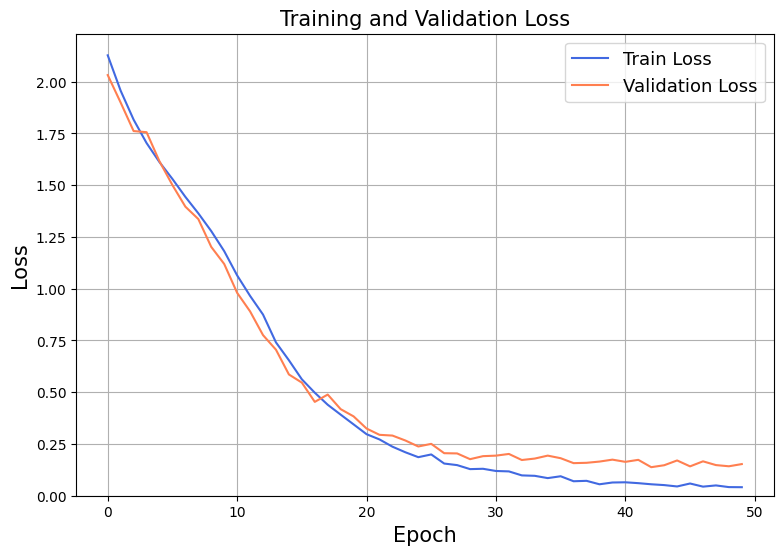

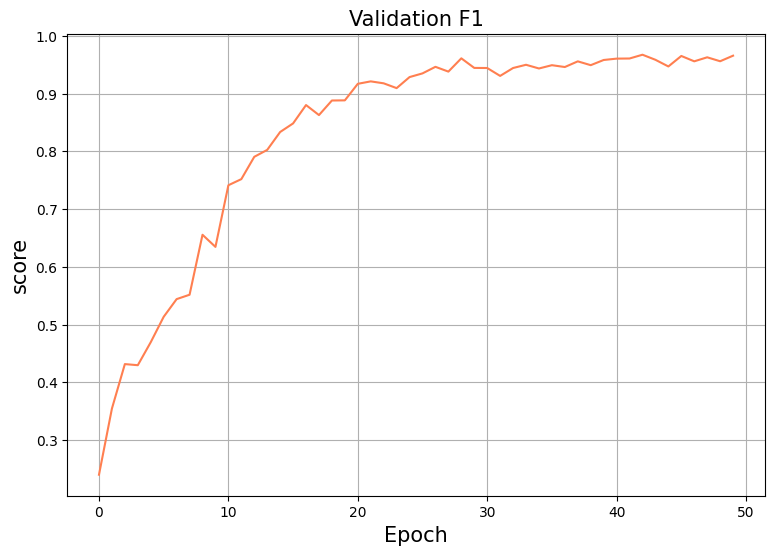

In [10]:
res50_test_loss, res50_test_f1 = test(resnet50, device, test_data, 10)
print(f'Test loss = {res50_test_loss}, accuracy = {res50_test_f1}')

Los_f1(res50_tra_los, res50_val_los, res50_val_f1) # Plot

In [11]:
# Resnet 18
resnet18 = timm.create_model('resnet18', pretrained=True, num_classes=num_classes).to(device)
# ResNet50 training
res18_tra_los, res18_val_los, res18_val_f1 = train(resnet18, train_dataloader, valid_dataloader, device, num_epochs=50, lr=0.001)
torch.save(resnet18, 'resnet18.pt')

100%|█████████████| 50/50 [07:15<00:00,  8.71s/it, train_loss=0.03214, valid_f1=0.97, validation_loss=0.09758]


Test loss = 0.08156521934275092, f1 = 0.9709181528091655


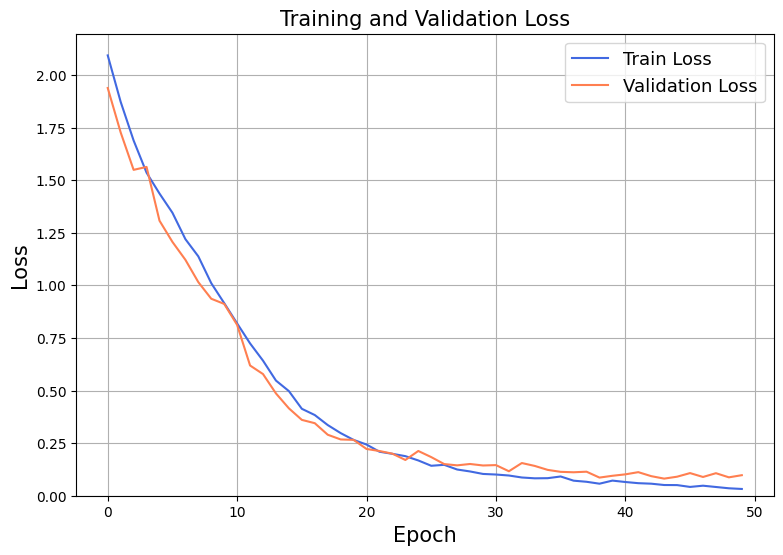

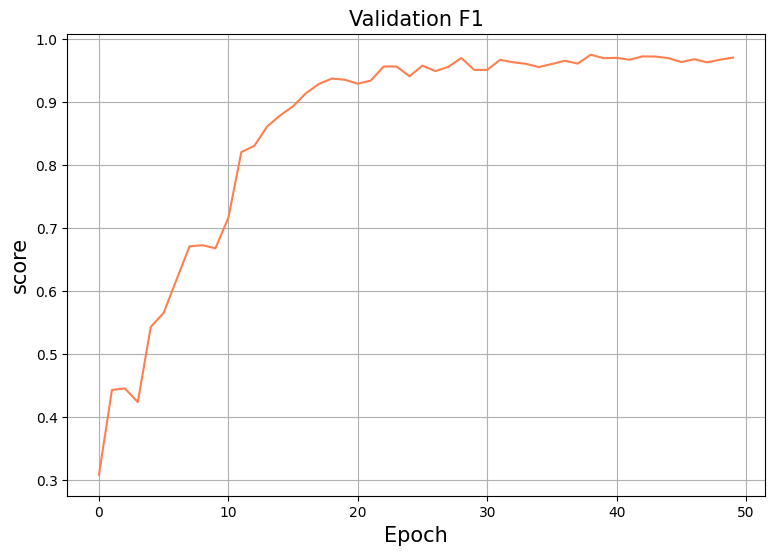

In [12]:
res18_test_loss, res18_test_f1 = test(resnet18, device, test_data)
print(f'Test loss = {res18_test_loss}, f1 = {res18_test_f1}')
Los_f1(res18_tra_los, res18_val_los, res18_val_f1) # Plot

### 2. ViT Model

In [13]:
#Pre—trained Vision Transformer Model
vit_model = timm.create_model('vit_small_patch16_224', pretrained=True).to(device)
vit_model.head = nn.Linear(vit_model.head.in_features, num_classes)

print(vit_model)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [14]:
vit_tra_los, vit_val_los, vit_val_f1 = train(vit_model, train_dataloader, valid_dataloader, device, num_epochs=10, lr=0.001)
torch.save(vit_model, 'vit.pt')

100%|█████████████| 10/10 [03:35<00:00, 21.56s/it, train_loss=0.00011, valid_f1=0.99, validation_loss=0.05682]


Test loss = 0.06682171448927544, f1 = 0.9809478261263713


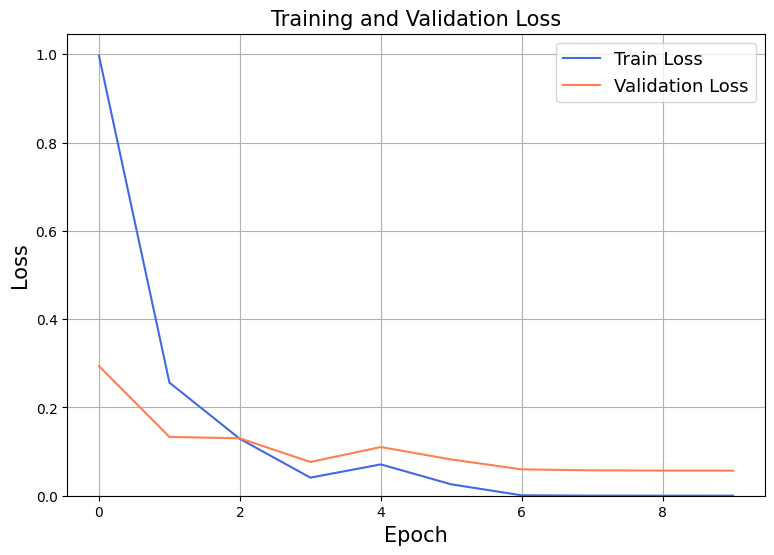

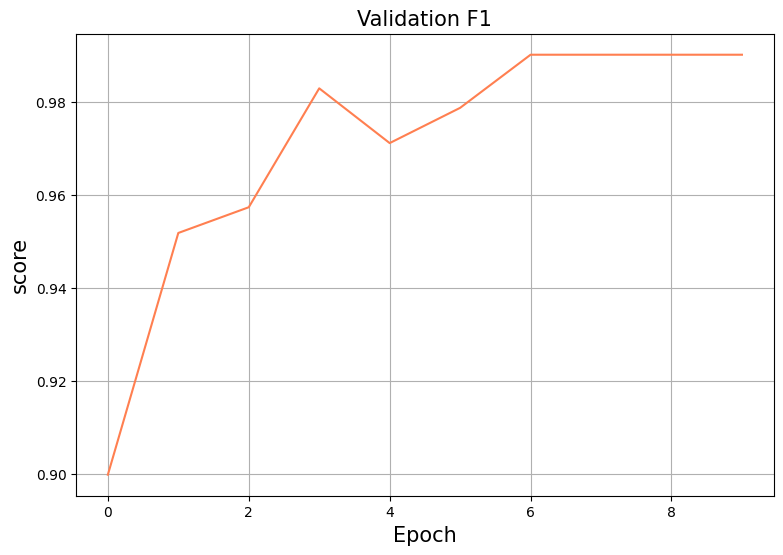

In [15]:
vit_test_loss, vit_test_f1 = test(vit_model, device, test_data,10)
print(f'Test loss = {vit_test_loss}, f1 = {vit_test_f1}')
Los_f1(vit_tra_los, vit_val_los, vit_val_f1) # Plot

In [16]:
vit_test_loss, vit_test_f1, eachf1 = testperclass(vit_model, device, test_data,10)

In [17]:
eachf1

{0: 0.9795918367346939,
 1: 1.0,
 2: 0.9714285714285714,
 3: 0.9795918367346939,
 4: 1.0,
 5: 0.9767441860465116,
 6: 0.9777777777777777,
 7: 0.9433962264150944,
 8: 1.0}

### 3. MobileNetV2

In [18]:
#MobileNetV2
mobilenet_model = models.mobilenet_v2(pretrained=True)
mobilenet_model.classifier[1] = nn.Linear(mobilenet_model.classifier[1].in_features, 9)
mobilenet_model = mobilenet_model.to(device)

/opt/homebrew/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
mob_tra_los, mob_val_los, mob_val_f1 = train(mobilenet_model, train_dataloader, valid_dataloader, device, num_epochs=10, lr=0.001)
torch.save(mobilenet_model, 'mobilenet.pt')

100%|█████████████| 10/10 [02:01<00:00, 12.16s/it, train_loss=0.00689, valid_f1=0.99, validation_loss=0.07070]


Test loss = 0.020243662605604517, f1 = 0.9901133786848073


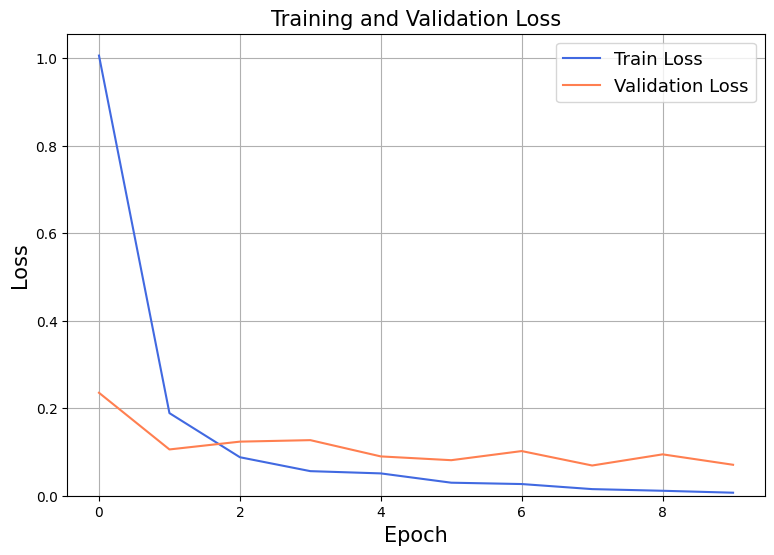

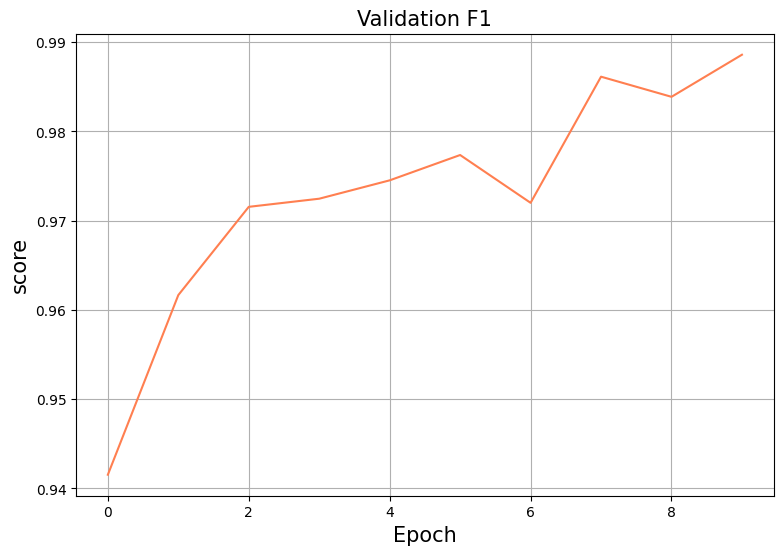

In [20]:
mob_test_loss, mob_test_f1 = test(mobilenet_model, device, test_data, 10)
print(f'Test loss = {mob_test_loss}, f1 = {mob_test_f1}')
Los_f1(mob_tra_los, mob_val_los, mob_val_f1) # Plot

### 4. CNN Model

In [21]:
import torch
from torch import nn
from torch.optim import Adam

# CNN
class RoadSign_CNN(nn.Module):
    def __init__(self):
        super(RoadSign_CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 14 * 14, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 9)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 512 * 14 * 14)
        x = self.classifier(x)
        return x

In [22]:
# CNN
cnn_model = RoadSign_CNN()
# CNN training
cnn_tra_los, cnn_val_los, cnn_val_f1 = train(cnn_model, train_dataloader, valid_dataloader, device, num_epochs=10, lr=0.001)
torch.save(cnn_model, 'cnn_model.pt')

100%|█████████████| 10/10 [02:34<00:00, 15.44s/it, train_loss=0.05468, valid_f1=0.97, validation_loss=0.11197]


Test loss = 0.15321148667929016, f1 = 0.9557095146963435


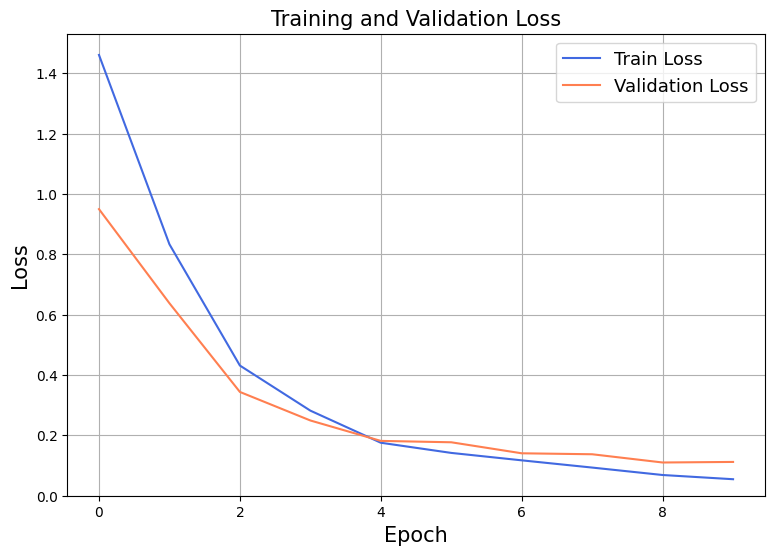

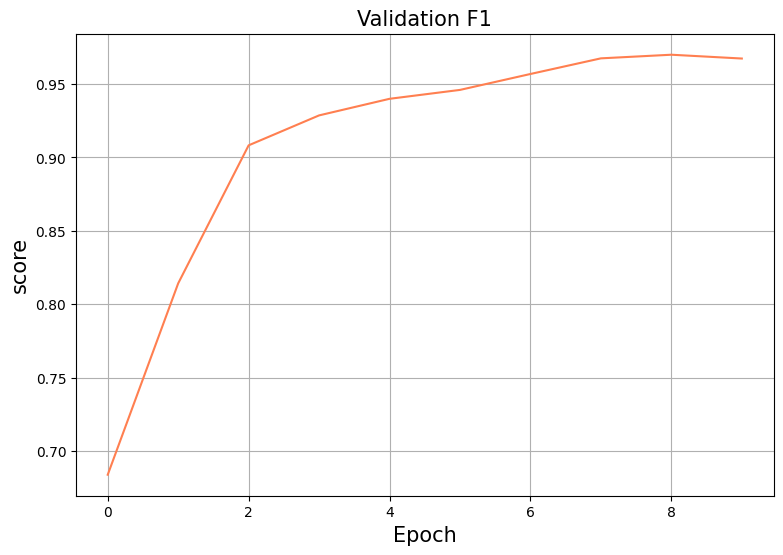

In [23]:
cnn_test_loss, cnn_test_f1 = test(cnn_model, device, test_data,10)
print(f'Test loss = {cnn_test_loss}, f1 = {cnn_test_f1}')
Los_f1(cnn_tra_los, cnn_val_los, cnn_val_f1) # Plot

##  4. Test Data  Augmentation

### 1. Load new and red test data

In [11]:
newtest_img_dir = 'test_new/images'
newtest_label_dir = 'test_new/labels'
batch_size = 16
newtest_data = CustomDataset(img_dir=newtest_img_dir, label_dir=newtest_label_dir, transform=transform)
newtest_dataloader = DataLoader(newtest_data, batch_size=batch_size, shuffle=False)


redtest_img_dir = 'red_filtered_data/images'
redtest_label_dir = 'red_filtered_data/labels'
batch_size = 16
redtest_data = CustomDataset(img_dir=redtest_img_dir, label_dir=redtest_label_dir, transform=transform)
redtest_dataloader = DataLoader(redtest_data, batch_size=batch_size, shuffle=False)

### 2. Model Performance

In [12]:
# ResNet 50
resnet50 = torch.load('resnet50.pt')

newres50_test_loss, newres50_test_f1 = test(resnet50, device, newtest_data) # New Test Data
print(f'Test loss = {newres50_test_loss}, accuracy = {newres50_test_f1}')


redres50_test_loss, redres50_test_f1 = test(resnet50, device, redtest_data) # Red Test Data
print(f'Test loss = {redres50_test_loss}, accuracy = {redres50_test_f1}')

Test loss = 1.105085589349843, accuracy = 0.8517945540585191
Test loss = 0.4701488327700645, accuracy = 0.8221891752379558


In [ ]:
# ResNet 18
resnet18 = torch.load('resnet18.pt')

newres18_test_loss, newres18_test_f1 = test(resnet18, device, newtest_data) # New Test Data
print(f'Test loss = {newres18_test_loss}, accuracy = {newres18_test_f1}')

resnest18 = torch.load('resnet18.pt')
redres18_test_loss, redres18_test_f1 = test(resnet18, device, redtest_data) # Red Test Data
print(f'Test loss = {redres18_test_loss}, accuracy = {redres18_test_f1}')

Test loss = 0.9566741399466991, accuracy = 79.76190476190476
Test loss = 1.1622102439403534, accuracy = 58.333333333333336


In [ ]:
# ViT Model
vit_model = torch.load('vit.pt')

newvit_test_loss, newres50_test_f1 = test(vit_model, device, newtest_data,16) # New Test Data
print(f'Test loss = {newres50_test_loss}, f1 = {newres50_test_f1}')


redvit_test_loss, redres50_test_f1 = test(vit_model, device, redtest_data,16) # Red Test Data
print(f'Test loss = {redres50_test_loss}, f1 = {redres50_test_f1}')

Test loss = 0.9266115613281727, f1 = 0.8632427974564298
Test loss = 1.3673022985458374, f1 = 0.9479719979719979


In [ ]:
# MobileNet Model
mobilenet_model = torch.load('mobilenet.pt')

newmob_test_loss, newmob_test_f1 = test(mobilenet_model, device, newtest_data) # New Test Data
print(f'Test loss = {newmob_test_loss}, f1 = {newmob_test_f1}')


redmob_test_loss, redmob_test_f1 = test(mobilenet_model, device, redtest_data) # Red Test Data
print(f'Test loss = {redmob_test_loss}, accuracy = {redmob_test_f1}')

Test loss = 1.7503920648014173, accuracy = 84.12698412698413
Test loss = 0.7991165786981582, accuracy = 77.56410256410257


In [ ]:
# CNN Model
cnn_model = torch.load('cnn_model.pt')

newcnn_test_loss, newcnn_test_f1 = test(cnn_model, device, newtest_data) # New Test Data
print(f'Test loss = {newcnn_test_loss}, accuracy = {newcnn_test_f1}')


redcnn_test_loss, redcnn_test_f1 = test(cnn_model, device, redtest_data) # Red Test Data
print(f'Test loss = {redcnn_test_loss}, accuracy = {redcnn_test_f1}')


Test loss = 1.3443478423869237, accuracy = 82.14285714285714
Test loss = 3.202943801879883, accuracy = 43.58974358974359


In [26]:
vit_tra_los, vit_val_los, vit_val_f1

([0.9966369093470944,
  0.25619023997908785,
  0.12882051213708134,
  0.04096178345403356,
  0.07095611839211602,
  0.02580909756060599,
  0.0009382863552473527,
  0.00022435928098165207,
  0.00013801367942460887,
  0.00011081075347997876],
 [0.293573236742685,
  0.13316661334964772,
  0.13004711099228886,
  0.07644572749335947,
  0.11027319021563609,
  0.08211384167178801,
  0.05973172814561241,
  0.05746450324469934,
  0.05697661829080337,
  0.05682320494386574],
 [0.8997459839994849,
  0.9518111823123143,
  0.9573530828112887,
  0.9829602783848004,
  0.9711696710174577,
  0.978760285635336,
  0.9902006361060197,
  0.9902006361060197,
  0.9902006361060197,
  0.9902006361060197])

In [27]:
res18_tra_los, res18_val_los, res18_val_f1

([2.0929599583416243,
  1.8721056241091056,
  1.6885211130963313,
  1.5356227354618466,
  1.4363668996656958,
  1.3450319817782517,
  1.2197567061458467,
  1.137718935718451,
  1.0102399584958373,
  0.9155421224944794,
  0.8188333814721471,
  0.7239382065866026,
  0.6419612540124243,
  0.5472782121244567,
  0.4972596493269831,
  0.41315630636274014,
  0.38348693544287316,
  0.33593490549400784,
  0.2976247326140981,
  0.2653160528217196,
  0.24325119856026675,
  0.20908108755378177,
  0.19913066229511536,
  0.18809154543674847,
  0.16762720219657293,
  0.142356685696863,
  0.14683248148604627,
  0.12462353237775142,
  0.11531928499884937,
  0.10353132823039464,
  0.10074548612060569,
  0.0960717838917412,
  0.08663734748349797,
  0.08273813222438899,
  0.0833851908638472,
  0.09147180844361438,
  0.07152505931256531,
  0.06628625779130784,
  0.05715887776195936,
  0.07184577312721399,
  0.06521051718160142,
  0.05961857018720843,
  0.05720419134013355,
  0.050898592209134404,
  0.05049

In [33]:
MobileNet_Tra_loss = [0.8143014795409992,0.2972403487750233,0.175842368579313,0.09063064787305072,0.06460744788037037,0.17347437711163724,0.07354842525424755,0.1053816742784993,0.12335095182198232,0.03485558536685287]
MobileNet_Val_loss = [0.16426687585839697,0.2999649497837391,0.10225816119630106,0.11786277223849496,0.1300294069646212,0.11919903107357027,0.1781992062194551,0.2126721619834973,0.41608035693249357,0.07051027893207056]
MobileNet_Val_f1 = [0.9551886792452831,0.9080188679245283,0.9740566037735849,0.9740566037735849,0.9740566037735849,0.9716981132075472,0.9433962264150944,0.9504716981132076,0.9009433962264151,0.9834905660377359]
vit_tra_los = [0.9966369093470944,
  0.25619023997908785,
  0.12882051213708134,
  0.04096178345403356,
  0.07095611839211602,
  0.02580909756060599,
  0.0009382863552473527,
  0.00022435928098165207,
  0.00013801367942460887,
  0.00011081075347997876]

vit_val_los = [0.293573236742685,
  0.13316661334964772,
  0.13004711099228886,
  0.07644572749335947,
  0.11027319021563609,
  0.08211384167178801,
  0.05973172814561241,
  0.05746450324469934,
  0.05697661829080337,
  0.05682320494386574]
vit_val_f1 = [0.8997459839994849,
  0.9518111823123143,
  0.9573530828112887,
  0.9829602783848004,
  0.9711696710174577,
  0.978760285635336,
  0.9902006361060197,
  0.9902006361060197,
  0.9902006361060197,
  0.9902006361060197]

res18_tra_los = [2.0929599583416243,
  1.8721056241091056,
  1.6885211130963313,
  1.5356227354618466,
  1.4363668996656958,
  1.3450319817782517,
  1.2197567061458467,
  1.137718935718451,
  1.0102399584958373,
  0.9155421224944794,
  0.8188333814721471,
  0.7239382065866026,
  0.6419612540124243,
  0.5472782121244567,
  0.4972596493269831,
  0.41315630636274014,
  0.38348693544287316,
  0.33593490549400784,
  0.2976247326140981,
  0.2653160528217196,
  0.24325119856026675,
  0.20908108755378177,
  0.19913066229511536,
  0.18809154543674847,
  0.16762720219657293,
  0.142356685696863,
  0.14683248148604627,
  0.12462353237775142,
  0.11531928499884937,
  0.10353132823039464,
  0.10074548612060569,
  0.0960717838917412,
  0.08663734748349797,
  0.08273813222438899,
  0.0833851908638472,
  0.09147180844361438,
  0.07152505931256531,
  0.06628625779130784,
  0.05715887776195936,
  0.07184577312721399,
  0.06521051718160142,
  0.05961857018720843,
  0.05720419134013355,
  0.050898592209134404,
  0.05049212701251154,
  0.04183983591838318,
  0.04763907393244317,
  0.04149258229777117,
  0.03535158698960738,
  0.0321449298764508]

res18_val_los = [1.9380287375561027,
  1.7267839132353318,
  1.5489457457564597,
  1.5628975796145061,
  1.30736393983974,
  1.2064150641130846,
  1.121527255967606,
  1.0152570272600927,
  0.9362668090088423,
  0.911769473275473,
  0.81189195430556,
  0.6189948323854181,
  0.5781904126322547,
  0.4862363036981849,
  0.4153202656050061,
  0.36049990113391434,
  0.3447687627617703,
  0.28992441521827567,
  0.2675349305188933,
  0.2654969956465932,
  0.22222586051929136,
  0.2124874604389418,
  0.19980548543119153,
  0.16991737393965556,
  0.212653998025628,
  0.18354004885741446,
  0.15044097190852776,
  0.1443826334854198,
  0.15086531701909248,
  0.1437004243002035,
  0.14555338566559692,
  0.11632501939311624,
  0.15535962061826572,
  0.14158172074293848,
  0.1227839210471355,
  0.11350140771774445,
  0.11148286059628738,
  0.11421427088464763,
  0.08622500603087246,
  0.09475243745133453,
  0.10156886051625533,
  0.11203993879648488,
  0.09300407967638484,
  0.081273638989863,
  0.09046168454251317,
  0.1075963192974044,
  0.08914578749884873,
  0.10706597574997347,
  0.08739401488077589,
  0.09757883801615018]

res18_val_f1 = [0.3079415872965159,
  0.4424841486475095,
  0.4449927951782494,
  0.4232881427898039,
  0.5423915278725119,
  0.5650340786115721,
  0.6180452005728205,
  0.6705666272883828,
  0.6723228015403915,
  0.6674554863414183,
  0.7160044753838568,
  0.8201517442069384,
  0.8300383819268107,
  0.8610063850933122,
  0.8783796025809751,
  0.8930018189033887,
  0.913774566938604,
  0.9284376309963913,
  0.9369777284021927,
  0.9350267529081964,
  0.9286767876467389,
  0.933790051097369,
  0.9560914066401863,
  0.956043884164932,
  0.9405446297627434,
  0.9575134372324161,
  0.9487591771378021,
  0.9555804227396458,
  0.9696290080640293,
  0.9506630491756227,
  0.9506818846131885,
  0.9667467064272325,
  0.9627513629249608,
  0.9603026039811267,
  0.9551982522242035,
  0.9601047052444946,
  0.9651515525494181,
  0.9607210712435985,
  0.9747828541930856,
  0.9692950653136518,
  0.9698295226008571,
  0.9668248098840206,
  0.9721168404020454,
  0.9718913468131866,
  0.969357649290703,
  0.9631614915731027,
  0.9675778821702217,
  0.9626625821899021,
  0.966909500766511,
  0.9702347610618287]


cnn_train_losses=[1.8001380148489914,
 1.4162601745716659,
 1.1632239329440712,
 0.6903318260950893,
 0.4821189958017503,
 0.3490179229043257,
 0.2611032990872392,
 0.24463709839306472,
 0.18892684990264508,
 0.15482812679389432,
 0.14040781217293122,
 0.13351117220609093,
 0.15912753023570528,
 0.15155978832705022,
 0.09411419688743819,
 0.08085977350859673,
 0.08234402894990199,
 0.08046268823965361,
 0.10150000277752393,
 0.09892518247969474]
cnn_valid_losses=[1.582018023313478,
 1.3074959558109904,
 0.9202555161575938,
 0.8391716331243515,
 0.397163248512634,
 0.38012676573423454,
 0.21652559760611417,
 0.2135620989598507,
 0.2493858037321547,
 0.15788989526836938,
 0.19568646149330793,
 0.204188491753844,
 0.21209029867422097,
 0.1462977383188297,
 0.19412255781191012,
 0.1777912896575926,
 0.12156082366506547,
 0.15821803783521401,
 0.15973885650313352,
 0.16058962222264517]
cnn_valid_f1_scores=[0.3443031215812888,
 0.5106049093880847,
 0.6335074792796608,
 0.6876751745586294,
 0.8581096841017883,
 0.8574533314974981,
 0.9352769441229414,
 0.9267805404974127,
 0.9166499826066148,
 0.9478146553505165,
 0.9248646549871951,
 0.9226075528104278,
 0.9189686719651687,
 0.9368415715599201,
 0.9406276880858727,
 0.955327035641894,
 0.9716689551591485,
 0.9455240635239969,
 0.9453190494665874,
 0.9623423675981547]



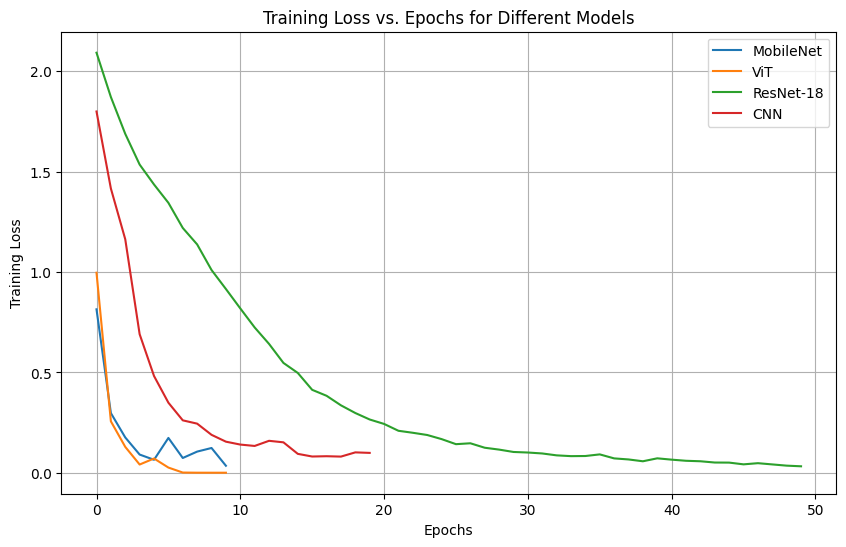

In [30]:
import matplotlib.pyplot as plt

# Plotting the training losses
plt.figure(figsize=(10, 6))
plt.plot(MobileNet_Tra_loss, label='MobileNet')
plt.plot(vit_tra_los, label='ViT')
plt.plot(res18_tra_los, label='ResNet-18')
plt.plot(cnn_train_losses, label='CNN')

plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss vs. Epochs for Different Models')
plt.legend()
plt.grid(True)
plt.show()

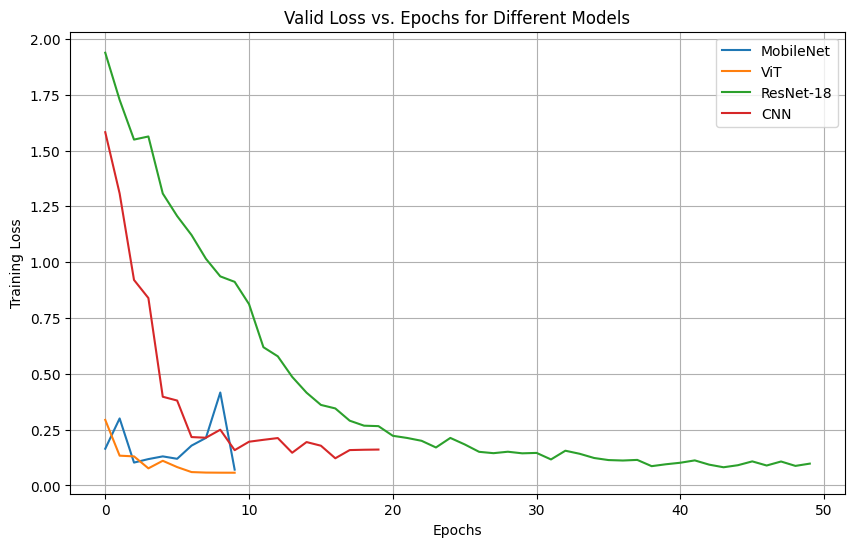

In [31]:
import matplotlib.pyplot as plt

# Plotting the training losses
plt.figure(figsize=(10, 6))
plt.plot(MobileNet_Val_loss, label='MobileNet')
plt.plot(vit_val_los, label='ViT')
plt.plot(res18_val_los, label='ResNet-18')
plt.plot(cnn_valid_losses, label='CNN')

plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Valid Loss vs. Epochs for Different Models')
plt.legend()
plt.grid(True)
plt.show()

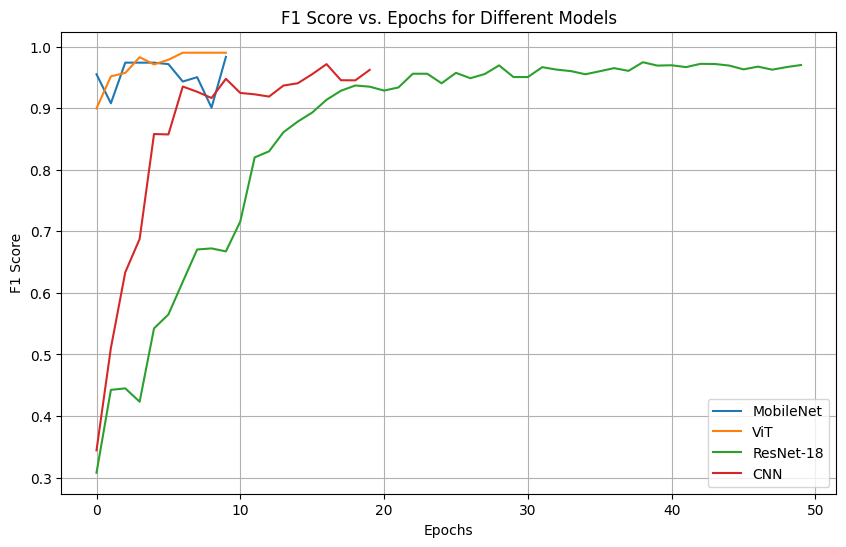

In [34]:
import matplotlib.pyplot as plt

# Plotting the training losses
plt.figure(figsize=(10, 6))
plt.plot(MobileNet_Val_f1, label='MobileNet')
plt.plot(vit_val_f1, label='ViT')
plt.plot(res18_val_f1, label='ResNet-18')
plt.plot(cnn_valid_f1_scores, label='CNN')

plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Epochs for Different Models')
plt.legend()
plt.grid(True)
plt.show()